In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import descartes
import shapely.wkt
import pyproj

from shapely.geometry import Point

In [93]:
prop = pd.read_csv(r"C:\Users\RedRagon\Documents\ProjetoIntegrador1\Data\Real_State_Properati.csv",sep='\t')

In [94]:
prop.shape

(17223, 9)

In [95]:
prop.head(5)

,property_type,place_name,country_name,state_name,lat,lon,price,currency,surface_total_in_m2
0,PH,Mataderos,Argentina,Capital Federal,-34.661824,-58.508839,62000.0,USD,55.0
1,apartment,Mataderos,Argentina,Capital Federal,-34.652262,-58.522982,72000.0,USD,55.0
2,apartment,Belgrano,Argentina,Capital Federal,-34.559873,-58.443362,138000.0,USD,45.0
3,apartment,Belgrano,Argentina,Capital Federal,-34.559873,-58.443362,195000.0,USD,65.0
4,PH,Mataderos,Argentina,Capital Federal,-34.652356,-58.501624,239000.0,USD,140.0


In [96]:
prop.isna().sum()

property_type          0
place_name             0
country_name           0
state_name             0
lat                    0
lon                    0
price                  0
currency               0
surface_total_in_m2    0
dtype: int64

In [97]:
prop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17223 entries, 0 to 17222
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   property_type        17223 non-null  object 
 1   place_name           17223 non-null  object 
 2   country_name         17223 non-null  object 
 3   state_name           17223 non-null  object 
 4   lat                  17223 non-null  float64
 5   lon                  17223 non-null  float64
 6   price                17223 non-null  float64
 7   currency             17223 non-null  object 
 8   surface_total_in_m2  17223 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.2+ MB


In [98]:
for col in prop.columns:
    print(col, "-", len(prop[col].unique()))

property_type - 4
place_name - 62
country_name - 1
state_name - 1
lat - 9714
lon - 9704
price - 2754
currency - 2
surface_total_in_m2 - 568


In [99]:
prop['property_type'].unique()

array(['PH', 'apartment', 'house', 'store'], dtype=object)

In [100]:
prop.groupby(by = 'property_type').count()['place_name'].sort_values(ascending = False)

property_type
apartment    14428
PH            1142
house          888
store          765
Name: place_name, dtype: int64

In [101]:
prop['property_type'].value_counts()/len(prop['property_type'])*100

apartment    83.771701
PH            6.630668
house         5.155896
store         4.441735
Name: property_type, dtype: float64

In [102]:
prop.groupby(by = 'currency').count()['place_name'].sort_values(ascending = False)

currency
USD    16700
ARS      523
Name: place_name, dtype: int64

In [103]:
prop['currency'].value_counts()/len(prop['currency'])*100

USD    96.963363
ARS     3.036637
Name: currency, dtype: float64

In [104]:
prop["price_usd"] = prop.apply(lambda x: x["price"] if x["currency"] == "USD" else x["price"]/117.41,axis=1)

In [105]:
prop.columns

Index(['property_type', 'place_name', 'country_name', 'state_name', 'lat',
       'lon', 'price', 'currency', 'surface_total_in_m2', 'price_usd'],
      dtype='object')

In [106]:
prop["preco_metro2"] = prop.price_usd / prop.surface_total_in_m2

In [107]:
prop.shape

(17223, 11)

In [108]:
prop[(prop.property_type == 'apartment') & (prop.surface_total_in_m2 == 0)]

,property_type,place_name,country_name,state_name,lat,lon,price,currency,surface_total_in_m2,price_usd,preco_metro2
2486,apartment,Palermo Soho,Argentina,Capital Federal,-34.589974,-58.425614,780000.0,USD,0.0,780000.0,inf
4872,apartment,Recoleta,Argentina,Capital Federal,-34.588818,-58.390648,320000.0,USD,0.0,320000.0,inf
5454,apartment,Caballito,Argentina,Capital Federal,-34.617348,-58.449404,68500.0,USD,0.0,68500.0,inf
6318,apartment,Palermo Hollywood,Argentina,Capital Federal,-34.582558,-58.432585,175000.0,USD,0.0,175000.0,inf
7170,apartment,Barracas,Argentina,Capital Federal,-34.641131,-58.369122,135000.0,USD,0.0,135000.0,inf
15888,apartment,Barrio Norte,Argentina,Capital Federal,-34.598727,-58.395851,112000.0,USD,0.0,112000.0,inf


In [109]:
prop.drop(index = list(prop[(prop.property_type == 'apartment') & (prop.surface_total_in_m2 == 0)].index),inplace = True)

In [110]:
for i in prop.property_type.unique():
    prop.drop(index = list(prop.loc[(prop.property_type == i) & (prop.preco_metro2 > 3*prop.preco_metro2.std())].index), inplace = True)

In [111]:
prop.columns

Index(['property_type', 'place_name', 'country_name', 'state_name', 'lat',
       'lon', 'price', 'currency', 'surface_total_in_m2', 'price_usd',
       'preco_metro2'],
      dtype='object')

In [112]:
prop.shape

(16770, 11)

In [113]:
df_bairros = pd.read_csv("Data/Neighborhoods.csv", encoding = 'latin1')
df_bairros.head()

,WKT,NEIGHBORHOOD,COMMUNE,PERIMETER,AREA
0,"POLYGON ((-58.4528200492791 -34.5959886570639,...",CHACARITA,15.0,7725.695228,3.118101e+06
1,"POLYGON ((-58.4655768128541 -34.5965577078058,...",PATERNAL,15.0,7087.513295,2.229829e+06
2,"POLYGON ((-58.4237529813037 -34.5978273383243,...",VILLA CRESPO,15.0,8132.699348,3.613584e+06
3,"POLYGON ((-58.4946097568899 -34.6148652395239,...",VILLA DEL PARQUE,11.0,7705.389797,3.399596e+06
4,"POLYGON ((-58.4128700313089 -34.6141162515854,...",ALMAGRO,5.0,8537.901368,4.050752e+06


In [114]:
df_bairros["WKT"] = df_bairros["WKT"].apply(shapely.wkt.loads)
geo_bairros = gpd.GeoDataFrame(df_bairros, geometry = 'WKT' )
type(geo_bairros)

geopandas.geodataframe.GeoDataFrame

C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


<AxesSubplot:>

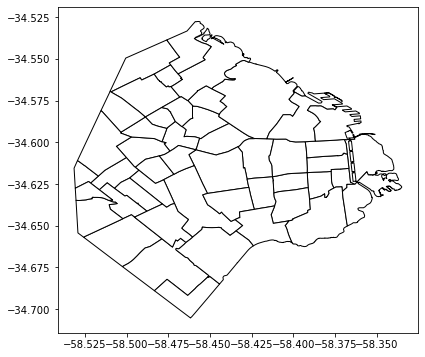

In [115]:
geo_bairros.plot(color = 'white', edgecolor='black', figsize=(10,6))

In [116]:
geometria = gpd.points_from_xy(prop['lon'],prop['lat'])

C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\geopandas\array.py:253: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


In [117]:
prop = gpd.GeoDataFrame(prop,
                        geometry = geometria
                        )

In [118]:
prop.loc[ : , ['geometry', 'lat', 'lon', 'property_type', 'place_name']]

,geometry,lat,lon,property_type,place_name
0,POINT (-58.50884 -34.66182),-34.661824,-58.508839,PH,Mataderos
1,POINT (-58.52298 -34.65226),-34.652262,-58.522982,apartment,Mataderos
2,POINT (-58.44336 -34.55987),-34.559873,-58.443362,apartment,Belgrano
3,POINT (-58.44336 -34.55987),-34.559873,-58.443362,apartment,Belgrano
4,POINT (-58.50162 -34.65236),-34.652356,-58.501624,PH,Mataderos
...,...,...,...,...,...
17218,POINT (-58.40252 -34.59921),-34.599214,-58.402519,apartment,Barrio Norte
17219,POINT (-58.39737 -34.58743),-34.587425,-58.397372,apartment,Recoleta
17220,POINT (-58.44268 -34.56369),-34.563685,-58.442683,apartment,Belgrano
17221,POINT (-58.44268 -34.56369),-34.563685,-58.442683,apartment,Belgrano


In [119]:
prop['property_place'] = prop['property_type'] + '_' + prop['place_name']

In [120]:
prop['avg_price_m2'] = prop.groupby('property_place')['preco_metro2'].transform('mean')

In [121]:
prop.head(2)

,property_type,place_name,country_name,state_name,lat,lon,price,currency,surface_total_in_m2,price_usd,preco_metro2,geometry,property_place,avg_price_m2
0,PH,Mataderos,Argentina,Capital Federal,-34.661824,-58.508839,62000.0,USD,55.0,62000.0,1127.272727,POINT (-58.50884 -34.66182),PH_Mataderos,1386.591733
1,apartment,Mataderos,Argentina,Capital Federal,-34.652262,-58.522982,72000.0,USD,55.0,72000.0,1309.090909,POINT (-58.52298 -34.65226),apartment_Mataderos,1776.706933


C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
C:\U

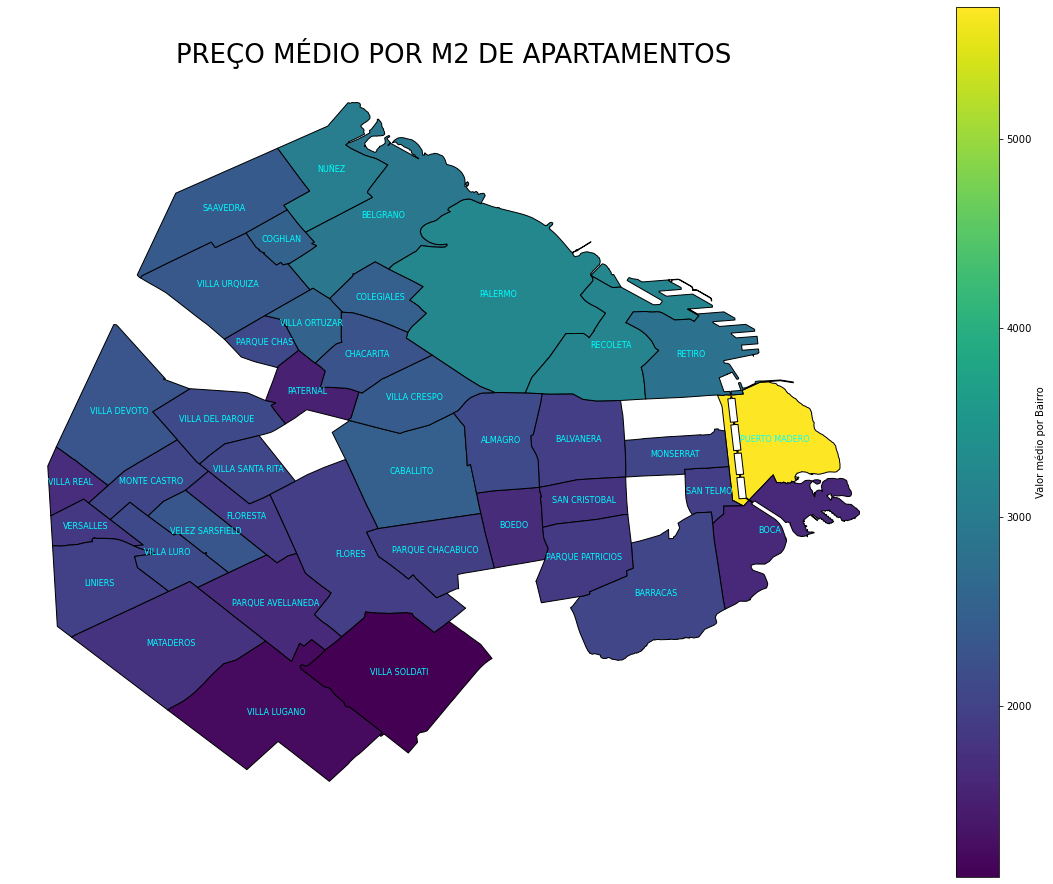

In [122]:
df_apart = prop.loc[ : , ['property_type', 'place_name', 'avg_price_m2']]

avg_bairro_apart = df_apart.loc[df_apart['property_type'] == 'apartment']
avg_bairro_apart['place_name'] = avg_bairro_apart['place_name'].str.upper()

geodata_apart = pd.merge(left=avg_bairro_apart, right=df_bairros, left_on='place_name', right_on='NEIGHBORHOOD', how='inner')
geodata_apart = geodata_apart.rename(columns={"WKT": "geometry"})
geodata_apart = geodata_apart.drop(columns=['NEIGHBORHOOD','COMMUNE','PERIMETER','AREA'])
geodata_apart = geodata_apart.drop_duplicates(subset=['place_name'])

geodf_apart = gpd.GeoDataFrame(geodata_apart)

ax = geodf_apart.loc[geodf_apart['property_type'] == 'apartment'].plot(
    figsize=(20,16),
    edgecolor='black',column='avg_price_m2',
    legend=True,
    legend_kwds={'label': "Valor médio por Bairro",'orientation':"vertical" })

for i in geodf_apart.index:
    plt.text(geodf_apart.geometry.centroid[i].coords[0][0], geodf_apart.geometry.centroid[i].coords[0][1], geodf_apart.place_name[i],
             fontsize=8, horizontalalignment='center', verticalalignment='center', color = 'cyan')
    
ax.set_axis_off();
ax.set_title("PREÇO MÉDIO POR M2 DE APARTAMENTOS",fontsize=26);

### AGORA COMEÇA A REGREÇÃO

In [123]:
prop.head(2)

,property_type,place_name,country_name,state_name,lat,lon,price,currency,surface_total_in_m2,price_usd,preco_metro2,geometry,property_place,avg_price_m2
0,PH,Mataderos,Argentina,Capital Federal,-34.661824,-58.508839,62000.0,USD,55.0,62000.0,1127.272727,POINT (-58.50884 -34.66182),PH_Mataderos,1386.591733
1,apartment,Mataderos,Argentina,Capital Federal,-34.652262,-58.522982,72000.0,USD,55.0,72000.0,1309.090909,POINT (-58.52298 -34.65226),apartment_Mataderos,1776.706933


In [124]:
prop.drop(columns=['price', 'currency','preco_metro2','avg_price_m2','property_place'], inplace= True)

In [125]:
prop.columns

Index(['property_type', 'place_name', 'country_name', 'state_name', 'lat',
       'lon', 'surface_total_in_m2', 'price_usd', 'geometry'],
      dtype='object')

In [126]:
aa = prop[prop.place_name == 'Retiro']
a = aa[aa.property_type == 'apartment']
bb = prop[prop.place_name == 'Recoleta']
b = bb[bb.property_type == 'apartment']
cc = prop[prop.place_name == 'Palermo']
c = cc[cc.property_type == 'apartment']
dd = prop[prop.place_name == 'Belgrano']
d = dd[dd.property_type == 'apartment']
ee = prop[prop.place_name == 'Nuñez']
e = ee[ee.property_type == 'apartment']
df_analise = pd.concat([a,b,c,d,e])
df212 = df_analise.sort_values(by='place_name')
dummiess = pd.get_dummies(df212.place_name)
data22 = pd.concat([df212, dummiess],axis=1)
data = data22.drop(columns = ['geometry','place_name'])
dumies = pd.get_dummies(data.property_type)
df = pd.concat([data,dumies],axis =1)
df = df.drop(columns = ['property_type'])
df

,country_name,state_name,lat,lon,surface_total_in_m2,price_usd,Belgrano,Nuñez,Palermo,Recoleta,Retiro,apartment
10106,Argentina,Capital Federal,-34.555270,-58.455786,77.0,180000.0,1,0,0,0,0,1
11109,Argentina,Capital Federal,-34.560210,-58.469261,111.0,210000.0,1,0,0,0,0,1
11110,Argentina,Capital Federal,-34.560210,-58.469261,42.0,114210.0,1,0,0,0,0,1
11112,Argentina,Capital Federal,-34.560210,-58.469261,98.0,230000.0,1,0,0,0,0,1
11113,Argentina,Capital Federal,-34.560210,-58.469261,113.0,263000.0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9444,Argentina,Capital Federal,-34.597040,-58.378666,52.0,199555.0,0,0,0,0,1,1
9582,Argentina,Capital Federal,-34.586849,-58.384689,161.0,470000.0,0,0,0,0,1,1
9919,Argentina,Capital Federal,-34.592865,-58.381134,166.0,500000.0,0,0,0,0,1,1
10455,Argentina,Capital Federal,-34.591852,-58.376688,70.0,230000.0,0,0,0,0,1,1


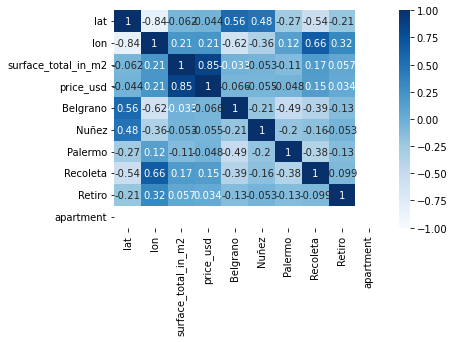

In [127]:
sns.heatmap(df.corr(), 
            annot = True, 
            vmin = -1, 
            cmap = 'Blues'
            );


<AxesSubplot:>

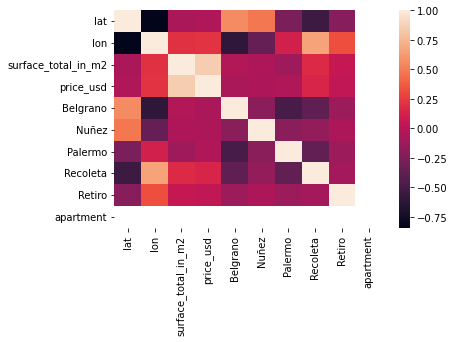

In [128]:
sns.heatmap(df.corr())

In [129]:
feature_cols = ['Belgrano', 'Nuñez', 'Palermo', 'Recoleta', 'Retiro', 'apartment', 'surface_total_in_m2']
X = df[feature_cols]
y = df.price_usd
print('X:',X.shape)
print('y:',y.shape)


X: (4073, 7)
y: (4073,)


In [130]:
from sklearn.linear_model import LinearRegression

In [131]:
model = LinearRegression()

In [132]:
model.fit(X, y)

LinearRegression()

In [133]:
print (model.intercept_)
print (model.coef_)

-32232.006736899202
[-11186.35130864  -4396.67592101  28330.19427398   7839.65015456
 -20586.81719888      0.           3437.54640667]


In [134]:
model.score(X,y)

0.7295870254915984

In [135]:
pred = model.predict(X)

In [136]:
from sklearn import metrics
import numpy as np
print ('MAE:', metrics.mean_absolute_error(y, pred))
print ('MSE:', metrics.mean_squared_error(y, pred))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(y, pred)))
print ('R2:', metrics.r2_score(y, pred))

MAE: 89775.49797629083
MSE: 28949015240.890312
RMSE: 170144.1013990503
R2: 0.7295870254915984


In [137]:
df_cultura = pd.read_csv("Data/actividades-culturales-2021.csv",sep=';')
cultura = df_cultura.drop(columns = ['descripcion_actividad','actividad','lugar','dirección','calle','altura','comuna','fecha_ini','fecha_fin','tipo','tipo_actividad','disciplina','se_suspende_por_lluvia','Links'])
datacul = cultura[cultura.Modalidad == 'Presencial']
datacul.isna().sum()

Modalidad            0
barrio              24
publico_objetivo     0
Gratuita             0
long                26
lat                 26
dtype: int64